# 🌍 COVID-19 Data Analysis

This notebook explores global COVID-19 trends using data from [Our World in Data](https://ourworldindata.org/covid-cases). It includes comparisons of new cases and vaccination rates for selected countries.

We'll focus on:
- New cases over time
- Vaccination progress
- Descriptive statistics
- Correlation between different metrics
- Regression analysis on vaccine uptake


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

print(sklearn.__version__)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


1.6.1


In [ ]:
# Load cleaned data
df = pd.read_csv('data/cleaned_covid.csv')
# In order to run this cell directly in the notebook, 
# comment out the line above and uncomment the one below
# df = pd.read_csv('../data/cleaned_covid.csv')
df['date'] = pd.to_datetime(df['date'])

print("Rows:", df.shape[0])
print("Columns:", df.shape[1])
df[['country', 'date']].head()


Rows: 459568
Columns: 61


,country,date
0,Afghanistan,2020-01-01
1,Afghanistan,2020-01-02
2,Afghanistan,2020-01-03
3,Afghanistan,2020-01-04
4,Afghanistan,2020-01-05


In [4]:
countries = ['Finland', 'South Africa', 'India', 'United States', 'Brazil']
df_subset = df[df['country'].isin(countries)]


In [5]:
# Define the columns you want
selected_cols = ['country', 'total_cases', 'total_deaths', 'total_vaccinations', 'population']
selected_cols = [col for col in selected_cols if col in df_subset.columns]

# Group by country and get the latest available record
summary_stats = df_subset[selected_cols].groupby('country').last().reset_index()

# Add per-million metrics
summary_stats['cases_per_million'] = (summary_stats['total_cases'] / summary_stats['population']) * 1_000_000
summary_stats['deaths_per_million'] = (summary_stats['total_deaths'] / summary_stats['population']) * 1_000_000

# Round for clarity (optional)
summary_stats = summary_stats.round({
    'cases_per_million': 1,
    'deaths_per_million': 1,
    'total_cases': 0,
    'total_deaths': 0,
    'total_vaccinations': 0
})

# Displaying these 2 values as integers for clarity
summary_stats['total_vaccinations'] = summary_stats['total_vaccinations'].astype('Int64')
summary_stats['population'] = summary_stats['population'].astype('Int64')

# Show final table
print("Summary Statistics by Country (with per-million rates):")
display(summary_stats)


Summary Statistics by Country (with per-million rates):


,country,total_cases,total_deaths,total_vaccinations,population,cases_per_million,deaths_per_million
0,Brazil,37715366.0,702747.0,516237120,210306358,179335.4,3341.5
1,Finland,1499712.0,11466.0,13327120,5569254,269284.2,2058.8
2,India,45044634.0,533664.0,2206868000,1425423157,31600.9,374.4
3,South Africa,4072955.0,102595.0,41798812,62378377,65294.3,1644.7
4,United States,103436829.0,1222309.0,676728770,341533996,302859.5,3578.9


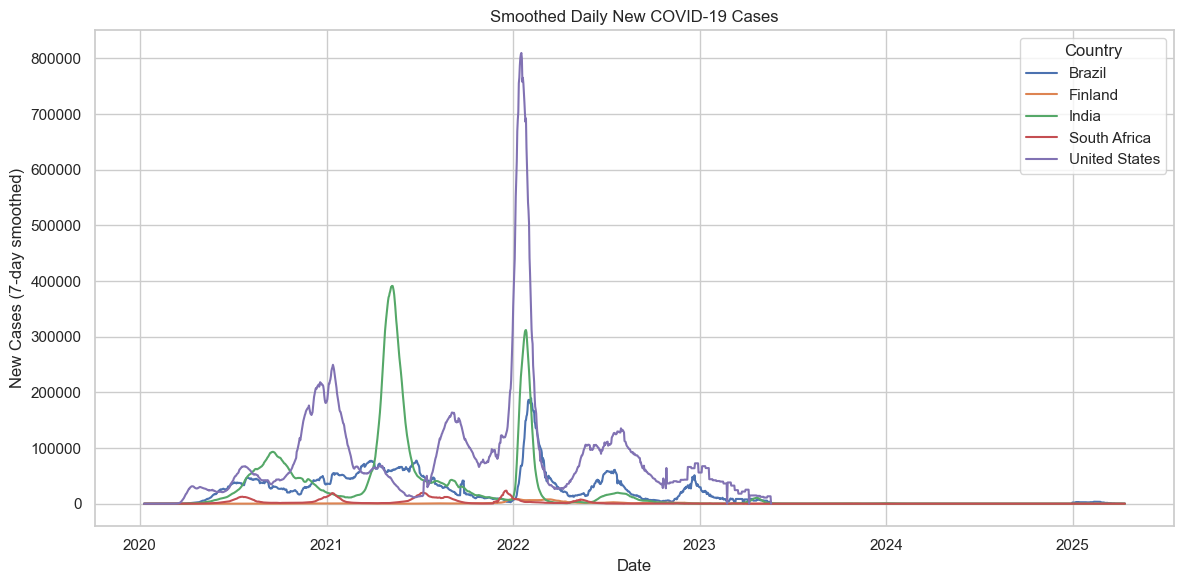

In [6]:
plt.figure()
sns.lineplot(data=df_subset, x='date', y='new_cases_smoothed', hue='country')
plt.title('Smoothed Daily New COVID-19 Cases')
plt.xlabel('Date')
plt.ylabel('New Cases (7-day smoothed)')
plt.legend(title='Country')
plt.tight_layout()
plt.show()


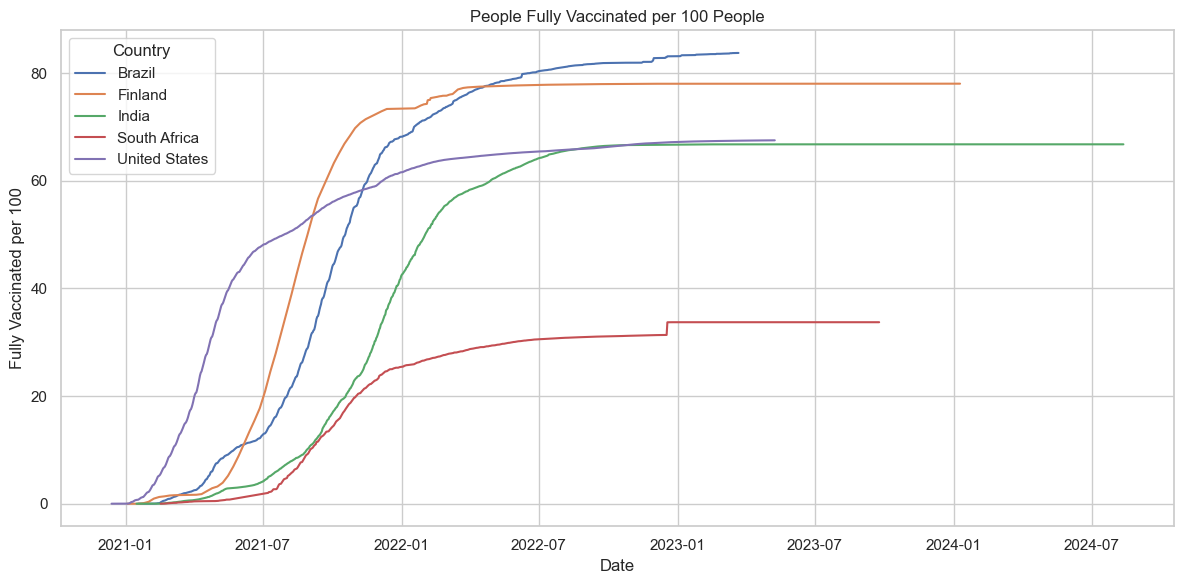

In [7]:
plt.figure()
sns.lineplot(data=df_subset, x='date', y='people_fully_vaccinated_per_hundred', hue='country')
plt.title('People Fully Vaccinated per 100 People')
plt.xlabel('Date')
plt.ylabel('Fully Vaccinated per 100')
plt.legend(title='Country')
plt.tight_layout()
plt.show()

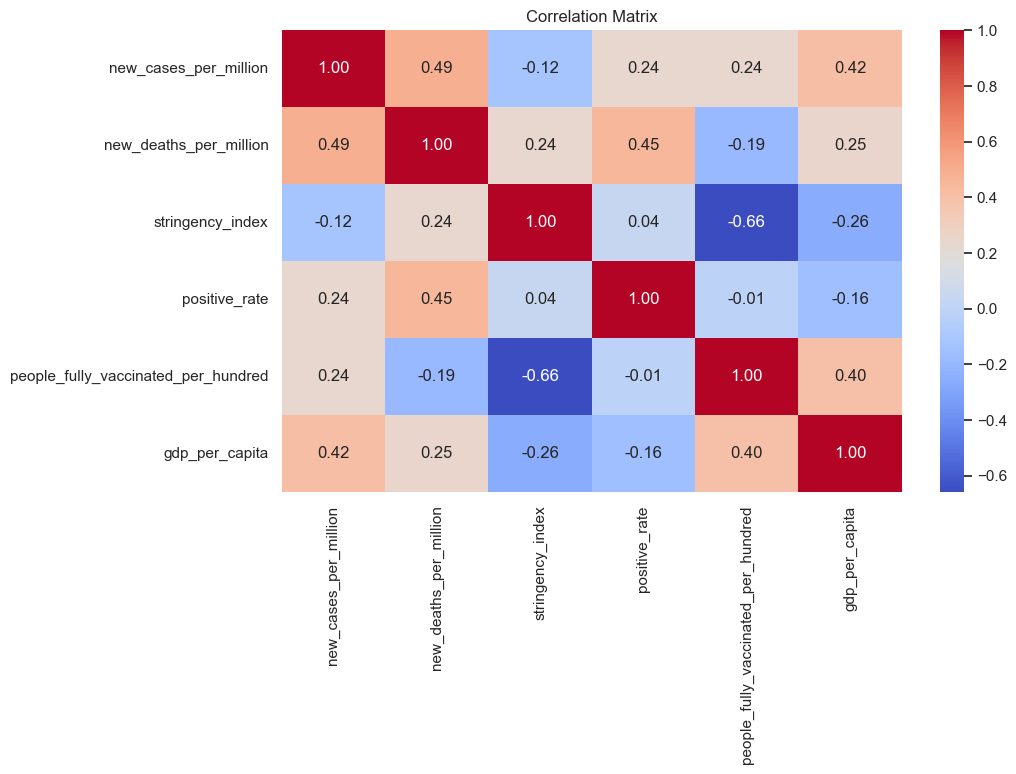

In [8]:
# Heatmap showing correlations between various parameters
numeric_cols = [
    'new_cases_per_million', 'new_deaths_per_million',
    'stringency_index', 'positive_rate',
    'people_fully_vaccinated_per_hundred', 'gdp_per_capita'
]

cor_df = df_subset[numeric_cols].dropna()
corr = cor_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [9]:
# Regression Analysis: What Explains Vaccination Uptake?

# Select relevant columns and drop missing values
features = [
    'gdp_per_capita',
    'human_development_index',
    'median_age',
    'population_density',
    'hospital_beds_per_thousand',
    'stringency_index',
    'people_fully_vaccinated_per_hundred'
]

df_reg = df[features].dropna()

# Modify target to be per 1000 people instead of per 100
df_reg['people_fully_vaccinated_per_thousand'] = df_reg['people_fully_vaccinated_per_hundred'] * 10

# Split predictors and target (adjusted)
X = df_reg.drop(['people_fully_vaccinated_per_hundred', 'people_fully_vaccinated_per_thousand'], axis=1)
y = df_reg['people_fully_vaccinated_per_thousand']

# Split predictors and target
#X = df_reg.drop('people_fully_vaccinated_per_hundred', axis=1)
#y = df_reg['people_fully_vaccinated_per_hundred']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Compute Root Mean Squared Error (RMSE) manually
mse = np.mean((y_test - y_pred) ** 2)
rmse = np.sqrt(mse)

print("R² Score:", r2_score(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

# Optional: Show coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
print("\nModel Coefficients:")
print(coef_df)

# Visualize Actual vs Predicted (per 1000 people)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Vaccination Rate (per 1000 people)')
plt.ylabel('Predicted Vaccination Rate (per 1000 people)')
plt.title('Actual vs Predicted: Vaccination per 1000 People')
plt.plot([0, 1000], [0, 1000], '--', color='gray')
plt.tight_layout()
plt.show()


NameError: name 'LinearRegression' is not defined